In [1]:
!pip install ucimlrepo

In [2]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split # Incorrect for time series! We need manual split.
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import math
import torch.optim as optim
import matplotlib.pyplot as plt # For plotting results

# Fetch dataset
ihepc = fetch_ucirepo(id=235)

# Combine features and targets
# The fetcher separates them, let's put them back together for easier time handling
df = pd.concat([ihepc.data.features, ihepc.data.targets], axis=1)

print("Original DataFrame Info:")
df.info()
print("\nOriginal DataFrame Head:")
print(df.head())
print("\nValue Counts for potential missing values ('?'):")
# Check specific columns known to have '?' issues
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
     if col in df.columns:
           print(f"Column '{col}': {df[col].isin(['?']).sum()} missing values")

/usr/local/lib/python3.11/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


Original DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB

Original DataFrame Head:
         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740 

In [3]:
# --- Preprocessing ---

# 1. Combine Date and Time, Set Index
print("\nPreprocessing: Setting Datetime Index...")
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)
df.sort_index(inplace=True) # Ensure data is chronologically sorted

# 2. Handle Missing Values ('?')
print("Preprocessing: Handling Missing Values ('?')...")
df.replace('?', np.nan, inplace=True)

# 3. Convert columns to numeric (important after replacing '?')
print("Preprocessing: Converting columns to numeric...")
numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col])

# 4. Impute Missing Numeric Values (e.g., using forward fill)
print(f"Preprocessing: Imputing {df.isnull().sum().sum()} NaN values using ffill...")
# Alternative: df.interpolate(method='linear', inplace=True)
# Alternative: Use mean/median of a rolling window, but ffill is often okay for short gaps
df.fillna(method='ffill', inplace=True)
# Check if any NaNs remain (might happen at the very beginning)
if df.isnull().sum().sum() > 0:
    print("Warning: NaNs remain after ffill, applying bfill...")
    df.fillna(method='bfill', inplace=True) # Fill remaining NaNs at the start

# 5. Resampling (HIGHLY RECOMMENDED for Transformer efficiency)
# From minute-level to hourly ('H') or 15-minute ('15T').
TARGET_COL = 'Global_active_power' # Define target column name
resample_freq = '15T'
print(f"Preprocessing: Resampling data to '{resample_freq}' frequency...")

# How to aggregate depends on the column's meaning
agg_dict = {
    'Global_active_power': 'mean',
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'sum', # Energy consumed over the hour
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum'
}
# Only include columns present in the dataframe
agg_dict = {k: v for k, v in agg_dict.items() if k in df.columns}

df_resampled = df.resample(resample_freq).agg(agg_dict)

# Check for NaNs introduced by resampling (if there are gaps > resample_freq)
if df_resampled.isnull().sum().sum() > 0:
    print(f"Warning: {df_resampled.isnull().sum().sum()} NaNs found after resampling. Applying ffill/bfill again.")
    df_resampled.fillna(method='ffill', inplace=True)
    df_resampled.fillna(method='bfill', inplace=True)


# 6. Feature Engineering (Time Features) - Add AFTER resampling
print("Preprocessing: Engineering time features...")
df_resampled['MinuteofHour'] = df_resampled.index.minute
df_resampled['HourOfDay'] = df_resampled.index.hour
df_resampled['DayOfWeek'] = df_resampled.index.dayofweek # Monday=0, Sunday=6
df_resampled['DayOfMonth'] = df_resampled.index.day
df_resampled['MonthOfYear'] = df_resampled.index.month
# df_resampled['WeekOfYear'] = df_resampled.index.isocalendar().week.astype(int)
# df_resampled['Year'] = df_resampled.index.year # Optional, might capture long term trend/changes

# Add user-mentioned external features (Temperature, Weather etc.) here
# Example: Assuming you have a weather_df indexed by datetime
# df_resampled = pd.merge(df_resampled, weather_df[['Temperature', 'WeatherCode']], left_index=True, right_index=True, how='left')
# Handle potential NaNs from merge (e.g., ffill/bfill weather data too)

print("\nProcessed DataFrame Info:")
df_resampled.info()
print("\nProcessed DataFrame Head:")
print(df_resampled.head())

# Define final feature lists based on the processed DataFrame
all_cols = df_resampled.columns.tolist()
time_feature_cols = ['MinuteofHour','HourOfDay', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear'] # Add others if engineered

# Features known ONLY in the past (relative to the prediction point)
# Includes the target itself and other measured variables
past_only_cols = ['Global_reactive_power', 'Voltage', 'Global_intensity',
                  'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
# Filter based on actual columns present after resampling/aggregation
past_only_cols = [col for col in past_only_cols if col in df_resampled.columns]

# All features used in the Encoder input window (target + past-only + time features)
# Order matters slightly for TSDataset if target_transform is separate
# Putting target first is convenient.
ENCODER_FEATURES = [TARGET_COL] + past_only_cols + time_feature_cols
# Filter based on actual columns present
ENCODER_FEATURES = [col for col in ENCODER_FEATURES if col in df_resampled.columns]

# Features used in the Decoder input window
# Target (shifted) + features KNOWN about the future (only time features here)
FUTURE_EXOG_COLS = time_feature_cols
DECODER_FEATURES = [TARGET_COL] + FUTURE_EXOG_COLS # Target handled specially in Dataset
# Filter based on actual columns present
DECODER_FEATURES = [col for col in DECODER_FEATURES if col in df_resampled.columns]

print(f"\nTarget Column: {TARGET_COL}")
print(f"Encoder Features ({len(ENCODER_FEATURES)}): {ENCODER_FEATURES}")
print(f"Decoder Features ({len(DECODER_FEATURES)}): {DECODER_FEATURES} (Target shifted + Future Exog)")
print(f"Future Exogenous Only ({len(FUTURE_EXOG_COLS)}): {FUTURE_EXOG_COLS}")


Preprocessing: Setting Datetime Index...
Preprocessing: Handling Missing Values ('?')...
Preprocessing: Converting columns to numeric...
Preprocessing: Imputing 181853 NaN values using ffill...
Preprocessing: Resampling data to '15T' frequency...


<ipython-input-3-41729325d010>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
<ipython-input-3-41729325d010>:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(resample_freq).agg(agg_dict)


Preprocessing: Engineering time features...

Processed DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138352 entries, 2006-12-16 17:15:00 to 2010-11-26 21:00:00
Freq: 15min
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Global_active_power    138352 non-null  float64
 1   Global_reactive_power  138352 non-null  float64
 2   Voltage                138352 non-null  float64
 3   Global_intensity       138352 non-null  float64
 4   Sub_metering_1         138352 non-null  float64
 5   Sub_metering_2         138352 non-null  float64
 6   Sub_metering_3         138352 non-null  float64
 7   MinuteofHour           138352 non-null  int32  
 8   HourOfDay              138352 non-null  int32  
 9   DayOfWeek              138352 non-null  int32  
 10  DayOfMonth             138352 non-null  int32  
 11  MonthOfYear            138352 non-null  int32  
dtypes: float64(7), int32(5)
m

In [4]:
# --- Train/Val/Test Split ---
total_len = len(df_resampled)
train_end_idx = int(total_len * 0.7)
val_end_idx = int(total_len * 0.85) # Train 70%, Val 15%, Test 15%

train_df = df_resampled.iloc[:train_end_idx]
val_df = df_resampled.iloc[train_end_idx:val_end_idx]
test_df = df_resampled.iloc[val_end_idx:]

print(f"\nData Split:")
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")


Data Split:
Train shape: (96846, 12)
Validation shape: (20753, 12)
Test shape: (20753, 12)


In [5]:
# --- Scaling ---
# Scale all features together for simplicity, including target
# We'll need to save the scaler to inverse_transform the target later
scaler = StandardScaler() # Or MinMaxScaler()

# Fit on training data (using the columns defined for the encoder, which is the superset)
scaler.fit(train_df[ENCODER_FEATURES])

# Save target scale parameters for inverse transform if needed separately
target_idx_in_encoder = ENCODER_FEATURES.index(TARGET_COL)
target_mean = scaler.mean_[target_idx_in_encoder]
target_scale = scaler.scale_[target_idx_in_encoder]
print(f"\nTarget Scaler: Mean={target_mean:.4f}, Scale={target_scale:.4f}")

# Transform all sets
# We scale the entire dataframes first, then the Dataset class will select columns
train_scaled = scaler.transform(train_df[ENCODER_FEATURES])
val_scaled = scaler.transform(val_df[ENCODER_FEATURES])
test_scaled = scaler.transform(test_df[ENCODER_FEATURES])

# Convert scaled arrays back to DataFrames for easier handling in Dataset class
train_df_scaled = pd.DataFrame(train_scaled, columns=ENCODER_FEATURES, index=train_df.index)
val_df_scaled = pd.DataFrame(val_scaled, columns=ENCODER_FEATURES, index=val_df.index)
test_df_scaled = pd.DataFrame(test_scaled, columns=ENCODER_FEATURES, index=test_df.index)

# Create a separate "target scaler" object for convenience (using fitted params)
class TargetScaler:
    def __init__(self, mean, scale):
        self.mean_ = np.array([mean])
        self.scale_ = np.array([scale])
        # Match sklearn scaler attributes if needed
        self.n_features_in_ = 1
        self.feature_names_in_ = [TARGET_COL]

    def transform(self, x):
         # Expects shape (n_samples, 1)
        return (x - self.mean_) / self.scale_

    def inverse_transform(self, x):
         # Expects shape (n_samples, 1) or similar broadcastable
        return (x * self.scale_) + self.mean_

target_scaler = TargetScaler(target_mean, target_scale)


Target Scaler: Mean=1.0828, Scale=1.0211


In [6]:
# --- Dataset and Dataloaders ---
M = 168 # Input sequence length (e.g., 168 hours = 1 week)
N = 24  # Output sequence length (e.g., 24 hours = 1 day)
BATCH_SIZE = 32

# Note: The TSDataset class expects the raw dataframes and column names.
# It will perform the slicing and dicing internally.
# We pass the *scaled* dataframes here.

# We need to adjust TSDataset slightly if we pass scaled dataframes directly
# OR adjust how we pass feature/target scalers if scaling happens inside TSDataset.

# Let's refine TSDataset to accept pre-scaled DataFrames for clarity here:

class TSDatasetScaled(Dataset):
    def __init__(self, data_scaled_df, target_col, all_feature_cols, future_exog_cols, M, N):
        """
        Args:
            data_scaled_df (pd.DataFrame): DataFrame with ALL relevant columns ALREADY SCALED.
                                           Index must be datetime.
            target_col (str): Name of the target column.
            all_feature_cols (list): List of ALL column names present in data_scaled_df (order matches scaling).
            future_exog_cols (list): List of column names for known future exogenous features (subset of all_feature_cols).
            M (int): Input sequence length (history).
            N (int): Output sequence length (forecast horizon).
        """
        self.data_scaled_df = data_scaled_df
        self.target_col = target_col
        self.all_feature_cols = all_feature_cols
        self.future_exog_cols = future_exog_cols
        self.M = M
        self.N = N

        # Indices for slicing numpy array derived from scaled DataFrame
        self.target_idx = all_feature_cols.index(target_col)
        self.future_exog_indices = [all_feature_cols.index(col) for col in future_exog_cols]

        # Extract numpy array for faster indexing
        self.data_scaled = data_scaled_df.values # Shape: (total_len, num_all_features)

    def __len__(self):
        return len(self.data_scaled) - self.M - self.N + 1

    def __getitem__(self, idx):
        hist_start = idx
        hist_end = idx + self.M
        pred_start = hist_end
        pred_end = hist_end + self.N

        # --- Encoder Input ---
        # Includes target, past exog, and time features for the history window
        encoder_input = self.data_scaled[hist_start:hist_end] # Shape: (M, num_all_features)

        # --- Decoder Input (for Teacher Forcing) ---
        # Needs:
        # 1. Target values from M-1 to M+N-1 (shifted right from target output)
        # 2. Future exogenous features from M to M+N
        decoder_input_target = self.data_scaled[hist_end-1 : pred_end-1, [self.target_idx]] # Shape: (N, 1)
        decoder_input_exog = self.data_scaled[pred_start:pred_end, self.future_exog_indices] # Shape: (N, num_future_exog)

        decoder_input = np.concatenate([decoder_input_target, decoder_input_exog], axis=1) # Shape: (N, 1 + num_future_exog)

        # --- Target Output ---
        # Only the target variable for the prediction window
        target_output = self.data_scaled[pred_start:pred_end, [self.target_idx]] # Shape: (N, 1)

        # Convert to tensors
        encoder_input = torch.tensor(encoder_input, dtype=torch.float32)
        decoder_input = torch.tensor(decoder_input, dtype=torch.float32)
        target_output = torch.tensor(target_output, dtype=torch.float32)

        return encoder_input, decoder_input, target_output


# Create datasets using the scaled data
train_dataset = TSDatasetScaled(train_df_scaled, TARGET_COL, ENCODER_FEATURES, FUTURE_EXOG_COLS, M, N)
val_dataset = TSDatasetScaled(val_df_scaled, TARGET_COL, ENCODER_FEATURES, FUTURE_EXOG_COLS, M, N)
test_dataset = TSDatasetScaled(test_df_scaled, TARGET_COL, ENCODER_FEATURES, FUTURE_EXOG_COLS, M, N)


# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) # Set num_workers > 0 for parallel loading if needed
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


# --- Check a batch ---
print("\nChecking DataLoader output shapes...")
encoder_input_batch, decoder_input_batch, target_output_batch = next(iter(train_loader))
print(f"Encoder Input Batch Shape: {encoder_input_batch.shape}") # (batch, M, num_encoder_features) -> num_all_features here
print(f"Decoder Input Batch Shape: {decoder_input_batch.shape}") # (batch, N, 1 + num_future_exog)
print(f"Target Output Batch Shape: {target_output_batch.shape}") # (batch, N, 1)


Checking DataLoader output shapes...
Encoder Input Batch Shape: torch.Size([32, 168, 12])
Decoder Input Batch Shape: torch.Size([32, 24, 6])
Target Output Batch Shape: torch.Size([32, 24, 1])


In [7]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1) # Shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe) # Register as buffer so it's not a model parameter

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, d_model]
        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [8]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_encoder_features, num_decoder_features,
                 d_model=128, nhead=8, num_encoder_layers=3,
                 num_decoder_layers=3, dim_feedforward=512,
                 dropout=0.1, output_seq_len=24, output_dim=1):
        super(TimeSeriesTransformer, self).__init__()
        self.d_model = d_model
        self.output_seq_len = output_seq_len # N

        # Input projection layers
        self.encoder_projection = nn.Linear(num_encoder_features, d_model)
        self.decoder_projection = nn.Linear(num_decoder_features, d_model)

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # PyTorch Transformer Module
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False # Expects (seq_len, batch, features)
        )

        # Output layer
        self.fc_out = nn.Linear(d_model, output_dim) # Predicts 1 feature (target)

        # Initialization
        self._init_weights()

    def _init_weights(self):
        # Initialize weights for linear layers
        initrange = 0.1
        self.encoder_projection.weight.data.uniform_(-initrange, initrange)
        self.decoder_projection.weight.data.uniform_(-initrange, initrange)
        self.fc_out.bias.data.zero_()
        self.fc_out.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask # Shape: (sz, sz)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None, memory_key_padding_mask=None):
        """
        Args:
            src: Encoder input, shape [batch_size, src_seq_len, num_encoder_features]
            tgt: Decoder input, shape [batch_size, tgt_seq_len, num_decoder_features]
            src_mask: Mask for source sequence attention (optional)
            tgt_mask: Mask for target sequence attention (required for decoder self-attention)
            src_padding_mask: Mask for padding in source sequence (optional)
            tgt_padding_mask: Mask for padding in target sequence (optional)
            memory_key_padding_mask: Mask for padding in memory (optional)

        Returns:
            output: Tensor, shape [batch_size, tgt_seq_len, output_dim]
        """
        # 1. Project inputs to d_model
        src_proj = self.encoder_projection(src) * math.sqrt(self.d_model)
        tgt_proj = self.decoder_projection(tgt) * math.sqrt(self.d_model)

        # 2. Permute to (seq_len, batch_size, d_model) for Transformer module
        src_perm = src_proj.permute(1, 0, 2) # [src_seq_len, batch_size, d_model]
        tgt_perm = tgt_proj.permute(1, 0, 2) # [tgt_seq_len, batch_size, d_model]

        # 3. Add positional encoding
        src_pos = self.pos_encoder(src_perm)
        tgt_pos = self.pos_encoder(tgt_perm)

        # 4. Generate target mask if not provided (standard subsequent mask)
        if tgt_mask is None:
            tgt_mask = self._generate_square_subsequent_mask(tgt.size(1)).to(tgt.device) # tgt_seq_len x tgt_seq_len

        # 5. Pass through Transformer
        transformer_output = self.transformer(
            src_pos,
            tgt_pos,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            memory_mask=None, # Not typically used unless specific cross-attention masking needed
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask # Use src padding mask for memory attention
        )
        # Output shape: (tgt_seq_len, batch_size, d_model)

        # 6. Final Linear Layer
        output = self.fc_out(transformer_output)
        # Output shape: (tgt_seq_len, batch_size, output_dim)

        # 7. Permute back to (batch_size, tgt_seq_len, output_dim)
        return output.permute(1, 0, 2)

In [9]:
# --- Model, Loss, Optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Define Hyperparameters (adjust as needed)
D_MODEL = 64 # Smaller embedding dim might be sufficient for hourly data
NHEAD = 4
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DIM_FEEDFORWARD = 256
DROPOUT = 0.1
LR = 0.0005 # Learning rate
EPOCHS = 25 # Number of epochs
CLIP_VALUE = 1.0 # Gradient clipping

# Get feature dimensions from the Dataset/Dataloader check
num_encoder_features = encoder_input_batch.shape[2]
num_decoder_features = decoder_input_batch.shape[2]
output_dim = target_output_batch.shape[2] # Should be 1

model = TimeSeriesTransformer(
    num_encoder_features=num_encoder_features,
    num_decoder_features=num_decoder_features,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
    output_seq_len=N, # N
    output_dim=output_dim # 1
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) # Optional scheduler

print(f"\nModel Initialized:")
print(f"  Input Encoder Features: {num_encoder_features}")
print(f"  Input Decoder Features: {num_decoder_features}")
print(f"  Output Dimension: {output_dim}")
# print(model) # Uncomment to print model architecture


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



Model Initialized:
  Input Encoder Features: 12
  Input Decoder Features: 6
  Output Dimension: 1


In [12]:
import torch.optim as optim

def train_epoch(model, dataloader, optimizer, criterion, device, clip_value=1.0):
    model.train()
    total_loss = 0.
    for batch_idx, (encoder_input, decoder_input, target_output) in enumerate(dataloader):
        encoder_input = encoder_input.to(device) # (batch, M, num_enc_feat)
        decoder_input = decoder_input.to(device) # (batch, N, num_dec_feat)
        target_output = target_output.to(device) # (batch, N, 1)

        optimizer.zero_grad()

        # Generate target mask for decoder self-attention
        tgt_seq_len = decoder_input.size(1)
        tgt_mask = model._generate_square_subsequent_mask(tgt_seq_len).to(device)
        # Forward pass
        prediction = model(src=encoder_input, tgt=decoder_input, tgt_mask=tgt_mask) # (batch, N, 1)

        # Calculate loss (compare prediction with target_output)
        loss = criterion(prediction, target_output)
        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value) # Gradient clipping
        optimizer.step()

        total_loss += loss.item()
    print("Working")
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        for batch_idx, (encoder_input, decoder_input, target_output) in enumerate(dataloader):
            encoder_input = encoder_input.to(device)
            decoder_input = decoder_input.to(device)
            target_output = target_output.to(device)

            # During evaluation, we *could* use teacher forcing (like above) for simplicity,
            # OR implement autoregressive inference for a more realistic performance measure.
            # Let's stick to teacher forcing here for simplicity matching the training loop.
            # For true inference performance, implement autoregressive prediction below.

            tgt_seq_len = decoder_input.size(1)
            tgt_mask = model._generate_square_subsequent_mask(tgt_seq_len).to(device)

            prediction = model(src=encoder_input, tgt=decoder_input, tgt_mask=tgt_mask)
            loss = criterion(prediction, target_output)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [13]:
# --- Training ---
print("\nStarting Training...")
best_val_loss = float('inf')

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, CLIP_VALUE)
    val_loss = evaluate(model, val_loader, criterion, device) # Uses teacher forcing for validation loss

    print(f'Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_transformer_model.pth')
        print(f'  -> Saved Best Model (Val Loss: {best_val_loss:.6f})')

    # if scheduler: scheduler.step()


Starting Training...
Working
Epoch 1/25 | Train Loss: 0.270779 | Val Loss: 0.257895
  -> Saved Best Model (Val Loss: 0.257895)
Working
Epoch 2/25 | Train Loss: 0.254026 | Val Loss: 0.250060
  -> Saved Best Model (Val Loss: 0.250060)
Working
Epoch 3/25 | Train Loss: 0.241403 | Val Loss: 0.259265
Working
Epoch 4/25 | Train Loss: 0.229497 | Val Loss: 0.268447
Working
Epoch 5/25 | Train Loss: 0.217401 | Val Loss: 0.271112
Working
Epoch 6/25 | Train Loss: 0.205980 | Val Loss: 0.290188
Working
Epoch 7/25 | Train Loss: 0.195327 | Val Loss: 0.300234
Working
Epoch 8/25 | Train Loss: 0.185979 | Val Loss: 0.295531
Working
Epoch 9/25 | Train Loss: 0.177641 | Val Loss: 0.301772
Working
Epoch 10/25 | Train Loss: 0.170883 | Val Loss: 0.300720
Working
Epoch 11/25 | Train Loss: 0.164325 | Val Loss: 0.320057
Working
Epoch 12/25 | Train Loss: 0.158632 | Val Loss: 0.322654
Working
Epoch 13/25 | Train Loss: 0.153805 | Val Loss: 0.318447
Working
Epoch 14/25 | Train Loss: 0.149277 | Val Loss: 0.323327
Worki


Loading best model for evaluation...

Running Autoregressive Evaluation on Test Set...

Test Set Autoregressive Metrics:
  MAE: 0.5808
  RMSE: 0.8112

MAE per prediction step:
  Step 1: 0.2791
  Step 2: 0.3855
  Step 3: 0.4521
  Step 4: 0.4887
  Step 5: 0.5127
  Step 6: 0.5349
  Step 7: 0.5521
  Step 8: 0.5664
  Step 9: 0.5781
  Step 10: 0.5869
  Step 11: 0.5961
  Step 12: 0.6057
  Step 13: 0.6158
  Step 14: 0.6250
  Step 15: 0.6308
  Step 16: 0.6345
  Step 17: 0.6390
  Step 18: 0.6456
  Step 19: 0.6557
  Step 20: 0.6631
  Step 21: 0.6677
  Step 22: 0.6700
  Step 23: 0.6720
  Step 24: 0.6809


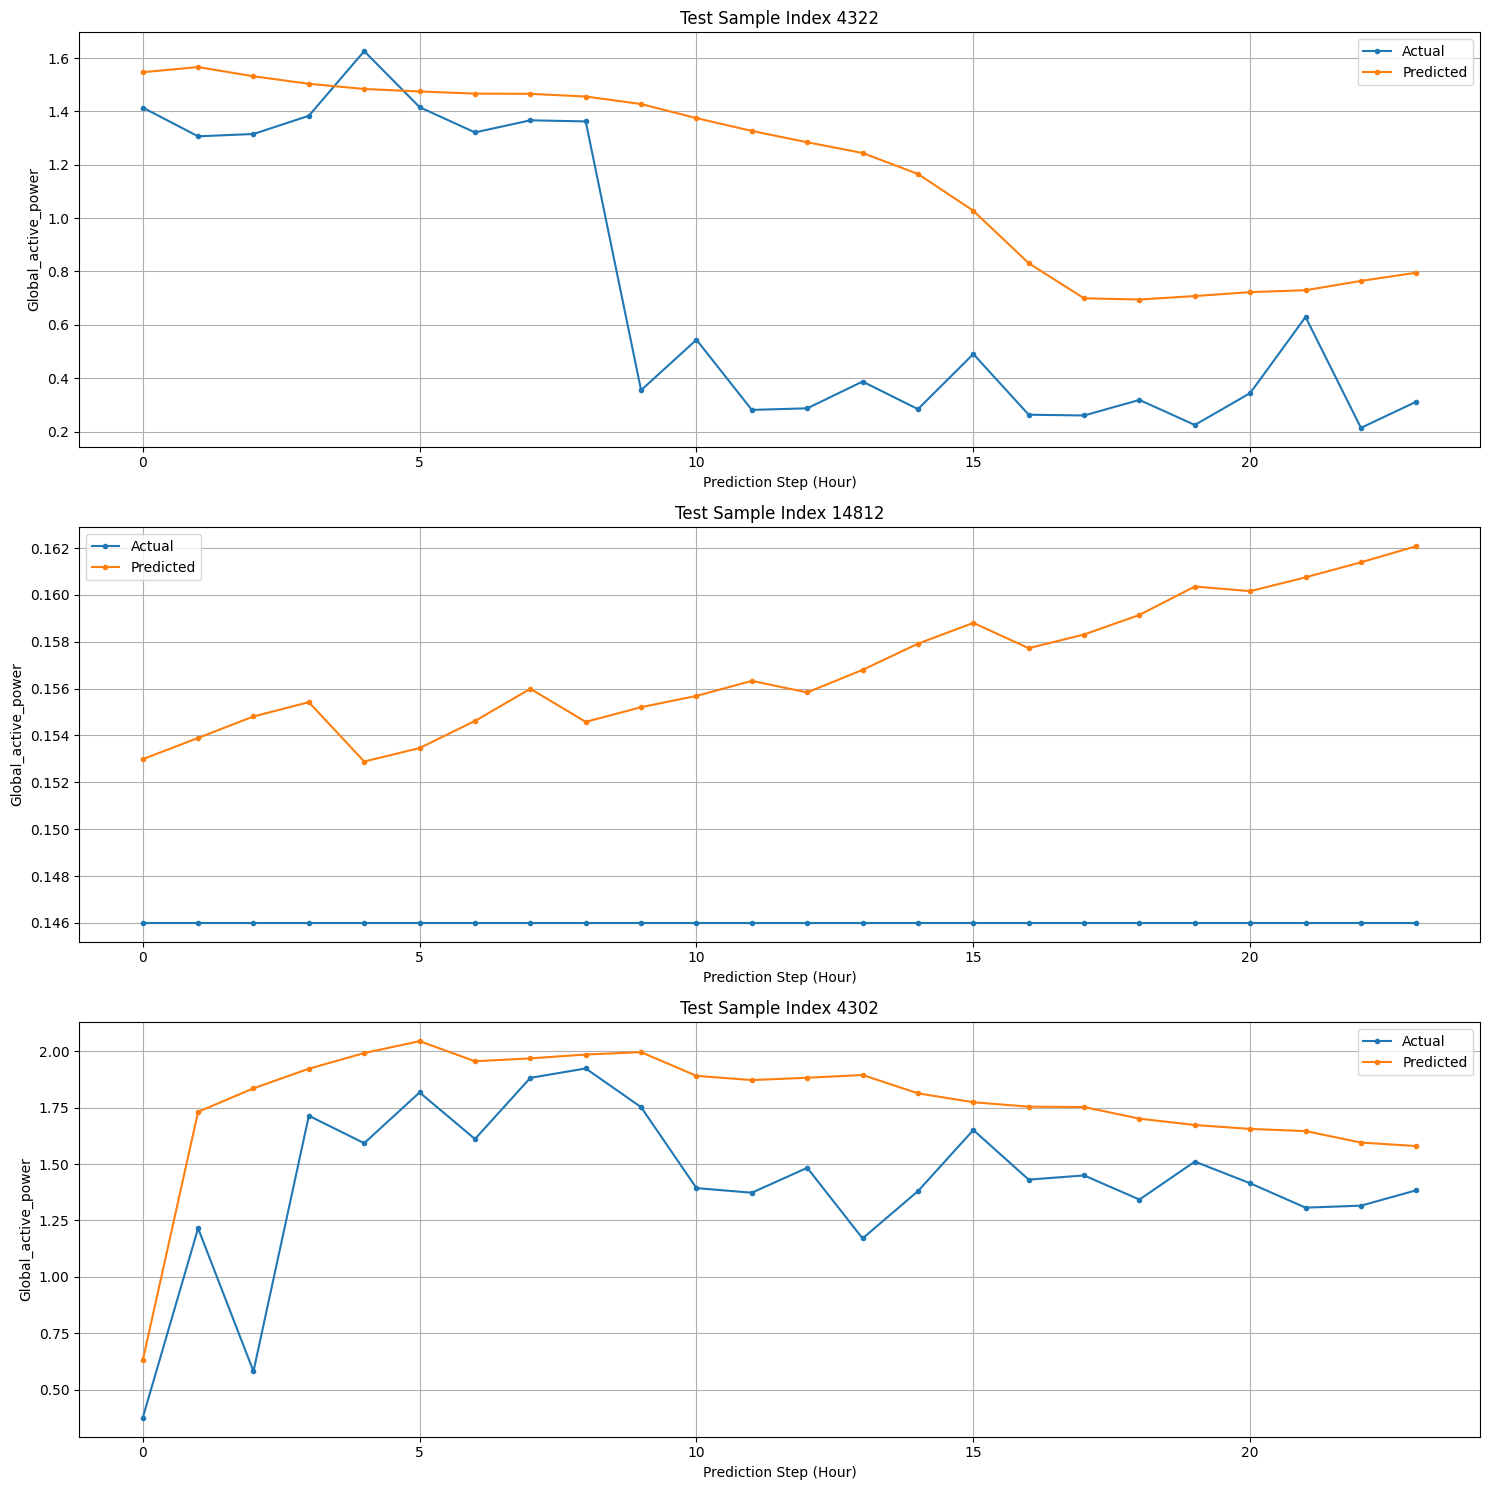

In [15]:
# --- Autoregressive Prediction on Test Set ---
print("\nLoading best model for evaluation...")
model.load_state_dict(torch.load('best_transformer_model.pth', map_location=device))

# Modify predict_autoregressive to accept scaled data structure

def predict_autoregressive_scaled(model, encoder_input_scaled, future_exog_scaled, N, device, target_idx, future_exog_indices):
    """
    Performs autoregressive prediction for N steps using pre-scaled data.

    Args:
        model: The trained Transformer model.
        encoder_input_scaled (torch.Tensor): Shape (1, M, num_all_features). Scaled historical data.
        future_exog_scaled (torch.Tensor): Shape (1, N, num_future_exog). Scaled known future exogenous features.
        N (int): Prediction horizon.
        device: Torch device.
        target_idx (int): Index of the target variable in the last dimension of encoder_input_scaled.
        future_exog_indices (list): Indices of future exogenous features in the last dim of encoder_input_scaled.

    Returns:
        torch.Tensor: Predicted sequence (scaled), shape (1, N, 1).
    """
    model.eval()
    encoder_input_scaled = encoder_input_scaled.to(device) # (1, M, num_all_feat)
    future_exog_scaled = future_exog_scaled.to(device)   # (1, N, num_fut_exog)

    # Get the last known target value (scaled)
    last_known_target_scaled = encoder_input_scaled[:, -1:, [target_idx]] # Shape (1, 1, 1)

    # Initialize decoder input for the first step
    first_step_exog = future_exog_scaled[:, 0:1, :] # Shape (1, 1, num_fut_exog)
    decoder_input_step = torch.cat([last_known_target_scaled, first_step_exog], dim=2) # Shape (1, 1, 1 + num_fut_exog)

    predictions_scaled_list = []

    with torch.no_grad():
        # Encode history once
        # Note: The model's internal projection expects the correct number of features
        # encoder_input_scaled already has the correct shape (batch, seq, features) expected by projection layer
        src_proj = model.encoder_projection(encoder_input_scaled) * math.sqrt(model.d_model)
        src_perm = src_proj.permute(1, 0, 2) # (M, 1, d_model)
        src_pos = model.pos_encoder(src_perm)
        memory = model.transformer.encoder(src_pos) # Shape (M, 1, d_model)

        # Autoregressive loop
        for i in range(N):
            tgt_seq_len = decoder_input_step.size(1)
            tgt_mask = model._generate_square_subsequent_mask(tgt_seq_len).to(device)

            # Project decoder input and add positional encoding
            tgt_proj = model.decoder_projection(decoder_input_step) * math.sqrt(model.d_model)
            tgt_perm = tgt_proj.permute(1, 0, 2) # (current_len, 1, d_model)
            tgt_pos = model.pos_encoder(tgt_perm)

            # Transformer Decoder step
            output = model.transformer.decoder(tgt_pos, memory, tgt_mask=tgt_mask)
            # output shape: (current_len, 1, d_model)

            # Get prediction for the last time step in the output sequence
            last_step_output = output[-1:, :, :] # Shape (1, 1, d_model)
            prediction_scaled = model.fc_out(last_step_output) # Shape (1, 1, 1)
            prediction_scaled = prediction_scaled.permute(1, 0, 2) # Shape (1, 1, 1) - batch first

            predictions_scaled_list.append(prediction_scaled)

            if i < N - 1:
                # Prepare input for the next step
                next_step_exog = future_exog_scaled[:, i+1:i+2, :]
                next_decoder_input_step = torch.cat([prediction_scaled, next_step_exog], dim=2) # Use predicted target

                # Append to the growing decoder input sequence
                decoder_input_step = torch.cat([decoder_input_step, next_decoder_input_step], dim=1)

    final_predictions_scaled = torch.cat(predictions_scaled_list, dim=1) # Shape (1, N, 1)
    return final_predictions_scaled


print("\nRunning Autoregressive Evaluation on Test Set...")
model.eval()
all_preds_scaled = []
all_targets_scaled = []

# Use a DataLoader with BATCH_SIZE=1 for easy iteration
test_loader_eval = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Get indices needed for the prediction function
target_idx = train_dataset.target_idx # Use index from dataset
future_exog_indices = train_dataset.future_exog_indices

for encoder_input, _, target_output in test_loader_eval:
    # encoder_input shape: (1, M, num_all_features)
    # target_output shape: (1, N, 1) - These are the ground truth targets (scaled)

    # Extract the required future exogenous features directly from the encoder input tensor
    # We need the features corresponding to the N steps *after* the encoder input window
    # The required features are already scaled within the dataset construction.
    # We need the future exogenous values for steps M to M+N-1.
    # The decoder_input constructed by the Dataset isn't directly used, but contains the info.
    # We need to manually reconstruct the future_exog tensor expected by predict_autoregressive_scaled.

    # Get the future exogenous features corresponding to the target window
    # These are present in the *original* scaled data at the correct time steps.
    # Find the index in the original test_df_scaled corresponding to the start of the target window
    # This requires tracking the index, which DataLoader doesn't easily provide.
    # Easier alternative: Extract from the encoder_input if M is large enough, or modify Dataset to return index.

    # --- Let's modify TSDatasetScaled to also return future_exog ---
    # (Add this inside TSDatasetScaled __getitem__)
    # future_exog_tensor = torch.tensor(self.data_scaled[pred_start:pred_end, self.future_exog_indices], dtype=torch.float32)
    # return encoder_input, decoder_input, target_output, future_exog_tensor

    # If Dataset is modified:
    # test_loader_eval = DataLoader(...) # Recreate loader
    # for encoder_input, _, target_output, future_exog in test_loader_eval:
    #     pred_scaled = predict_autoregressive_scaled(
    #         model, encoder_input, future_exog.unsqueeze(0), N, device, target_idx, future_exog_indices
    #     )
    #     all_preds_scaled.append(pred_scaled.cpu().numpy())
    #     all_targets_scaled.append(target_output.cpu().numpy())

    # --- Workaround without modifying Dataset: Reconstruct future exog ---
    # This assumes the indices align perfectly, which they should with shuffle=False
    # Get the indices corresponding to the target window within the test_df_scaled
    # current_idx = test_loader_eval.batch_sampler.sampler.first_index # Approximate start index (needs custom sampler maybe)
    # -> This gets complicated quickly. Modifying Dataset is cleaner.

    # *** Assuming Dataset is modified to return future_exog_tensor: ***
    pass # Placeholder - run the loop below after modifying TSDatasetScaled

# Recreate DataLoader after modifying Dataset
class TSDatasetScaled(Dataset): # Copy the class from above and add the return line
    def __init__(self, data_scaled_df, target_col, all_feature_cols, future_exog_cols, M, N):
        self.data_scaled_df = data_scaled_df
        self.target_col = target_col
        self.all_feature_cols = all_feature_cols
        self.future_exog_cols = future_exog_cols
        self.M = M
        self.N = N
        self.target_idx = all_feature_cols.index(target_col)
        self.future_exog_indices = [all_feature_cols.index(col) for col in future_exog_cols]
        self.data_scaled = data_scaled_df.values

    def __len__(self):
        return len(self.data_scaled) - self.M - self.N + 1

    def __getitem__(self, idx):
        hist_start = idx
        hist_end = idx + self.M
        pred_start = hist_end
        pred_end = hist_end + self.N

        encoder_input = self.data_scaled[hist_start:hist_end]
        decoder_input_target = self.data_scaled[hist_end-1 : pred_end-1, [self.target_idx]]
        decoder_input_exog = self.data_scaled[pred_start:pred_end, self.future_exog_indices]
        decoder_input = np.concatenate([decoder_input_target, decoder_input_exog], axis=1)
        target_output = self.data_scaled[pred_start:pred_end, [self.target_idx]]

        # Extract future exog features separately for inference function
        future_exog_tensor_np = self.data_scaled[pred_start:pred_end, self.future_exog_indices]

        encoder_input = torch.tensor(encoder_input, dtype=torch.float32)
        decoder_input = torch.tensor(decoder_input, dtype=torch.float32)
        target_output = torch.tensor(target_output, dtype=torch.float32)
        future_exog_tensor = torch.tensor(future_exog_tensor_np, dtype=torch.float32) # Added return

        return encoder_input, decoder_input, target_output, future_exog_tensor

test_dataset_eval = TSDatasetScaled(test_df_scaled, TARGET_COL, ENCODER_FEATURES, FUTURE_EXOG_COLS, M, N)
test_loader_eval = DataLoader(test_dataset_eval, batch_size=1, shuffle=False, num_workers=0)

for encoder_input, _, target_output, future_exog in test_loader_eval:
     # encoder_input shape: (1, M, num_all_features)
     # target_output shape: (1, N, 1)
     # future_exog shape: (1, N, num_future_exog) - needs unsqueeze for batch dim
    pred_scaled = predict_autoregressive_scaled(
    model, encoder_input, future_exog, N, device, target_idx, future_exog_indices # Remove unsqueeze(0)
  )
    all_preds_scaled.append(pred_scaled.cpu().numpy())
    all_targets_scaled.append(target_output.cpu().numpy()) # target_output is already (1, N, 1)

# Concatenate results
all_preds_scaled = np.concatenate(all_preds_scaled, axis=0) # Shape: (num_samples, N, 1)
all_targets_scaled = np.concatenate(all_targets_scaled, axis=0) # Shape: (num_samples, N, 1)

# Inverse transform using the target_scaler
all_preds_actual = target_scaler.inverse_transform(all_preds_scaled.reshape(-1, 1)).reshape(all_preds_scaled.shape)
all_targets_actual = target_scaler.inverse_transform(all_targets_scaled.reshape(-1, 1)).reshape(all_targets_scaled.shape)

# Calculate Metrics (Example: MAE and RMSE averaged over all N steps)
mae = np.mean(np.abs(all_preds_actual - all_targets_actual))
rmse = np.sqrt(np.mean((all_preds_actual - all_targets_actual)**2))

print(f"\nTest Set Autoregressive Metrics:")
print(f"  MAE: {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")

# Optional: Calculate metrics per step
mae_per_step = np.mean(np.abs(all_preds_actual - all_targets_actual), axis=(0, 2)) # Avg over samples, keep step dim
rmse_per_step = np.sqrt(np.mean((all_preds_actual - all_targets_actual)**2, axis=(0, 2)))

print("\nMAE per prediction step:")
for i in range(N):
    print(f"  Step {i+1}: {mae_per_step[i]:.4f}")

# Plot some examples
num_plots = 3
plot_indices = np.random.choice(len(all_preds_actual), num_plots, replace=False)

plt.figure(figsize=(15, 5 * num_plots))
for i, idx in enumerate(plot_indices):
    plt.subplot(num_plots, 1, i + 1)
    plt.plot(range(N), all_targets_actual[idx, :, 0], label='Actual', marker='.')
    plt.plot(range(N), all_preds_actual[idx, :, 0], label='Predicted', marker='.')
    plt.title(f'Test Sample Index {idx}')
    plt.xlabel('Prediction Step (Hour)')
    plt.ylabel(TARGET_COL)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()